In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Data/Data_Bank/230k.json',
                load_vocabulary = True,
                      image_padding = True,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )


In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 579 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:
# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s
def findPositions(image):
    positions = np.nonzero(image)
    top = positions[0].min()
    bottom = positions[0].max()
    left = positions[1].min()
    right = positions[1].max()
    image = cv2.rectangle(image, (left-1, top-1), (right+1, bottom+1), (0, 0, 0), 0)
    return image



In [6]:
model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/Printed1_2D600_350_xs.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
scripted = lit_model.to_torchscript()


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_recursive.py:262: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


516


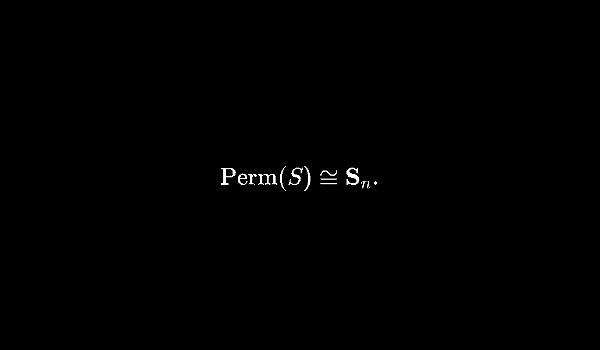

None

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong \mathrm { S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [15]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/zarhin.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)
print(w)
# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Downscaling big images
if w > 600:
    new_w = 600
    new_h = int(new_w * aspect)
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    
    
if w<200:
    image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]
elif w < 350:
    image_tensor = Image_Transforms.test_transform_with_padding_small(image=np.array(image))['image'][:1]
elif w<600:
    image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
else:
    image_tensor = Image_Transforms.test_transform_with_padding_xl(image=np.array(image))['image'][:1]
    
image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]    
    
    
    
print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


(138, 600, 3)


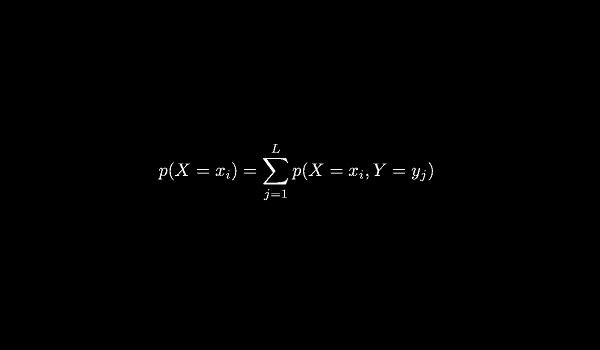

None

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [16]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Downscaling big images
if w > 600:
    new_w = 600
    new_h = int(new_w * aspect)
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

print(image.shape)
if w<200:
    image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]
elif w < 350:
    image_tensor = Image_Transforms.test_transform_with_padding_small(image=np.array(image))['image'][:1]
elif w<600:
    image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
else:
    image_tensor = Image_Transforms.test_transform_with_padding_xl(image=np.array(image))['image'][:1]
    
image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]    


print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))


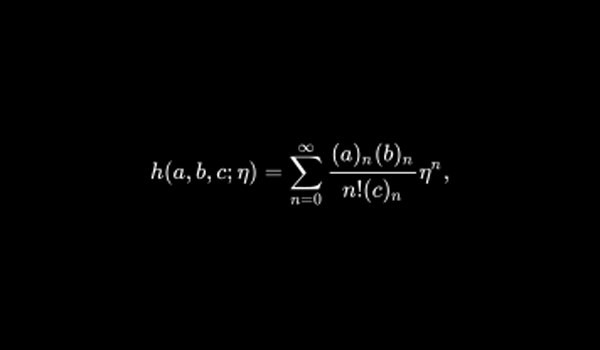

None

Predicted formula:
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { n } } { n ! ( c ) _ { n } } \eta ^ { n } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [17]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Downscaling big images
if w > 600:
    new_w = 600
    new_h = int(new_w * aspect)
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

if w<200:
    image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]
elif w < 350:
    image_tensor = Image_Transforms.test_transform_with_padding_small(image=np.array(image))['image'][:1]
elif w<600:
    image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
else:
    image_tensor = Image_Transforms.test_transform_with_padding_xl(image=np.array(image))['image'][:1]
    
image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]    

    
print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

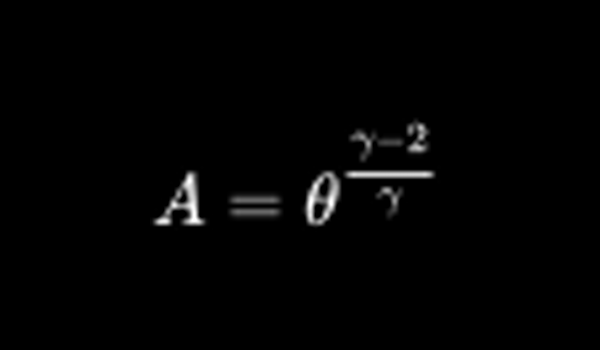

None

Predicted formula:
 <S> A = \theta ^ { \frac { \gamma - 2 } { \gamma } } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [18]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Downscaling big images
if w > 600:
    new_w = 600
    new_h = int(new_w * aspect)
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)


if w<200:
    image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]
elif w < 350:
    image_tensor = Image_Transforms.test_transform_with_padding_small(image=np.array(image))['image'][:1]
elif w<600:
    image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
else:
    image_tensor = Image_Transforms.test_transform_with_padding_xl(image=np.array(image))['image'][:1]
    
image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]    

    
print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

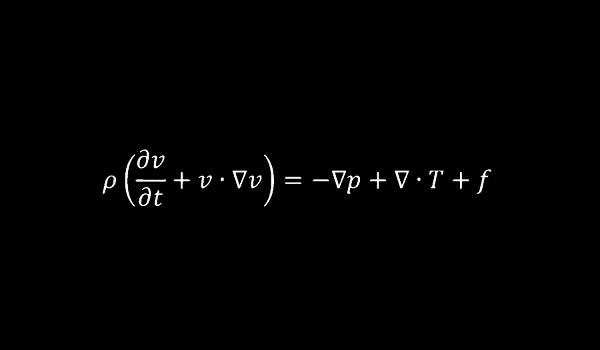

None

Predicted formula:
 <S> O \left( \frac { \partial } { \bar { \partial } } t } \epsilon \, { \cal V } \, \epsilon \, \psi \, \right) = - \psi { \cal P } \, + \, \psi \, \tau \, T \, \tau \, \ell } \, \epsilon \, f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [23]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Downscaling big images
if w > 600:
    new_w = 600
    new_h = int(new_w * aspect)
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)


if w<200:
    image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]
elif w < 350:
    image_tensor = Image_Transforms.test_transform_with_padding_small(image=np.array(image))['image'][:1]
elif w<600:
    image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
else:
    image_tensor = Image_Transforms.test_transform_with_padding_xl(image=np.array(image))['image'][:1]
    
    
image_tensor = Image_Transforms.test_transform_with_padding_medium(image=np.array(image))['image'][:1]    

print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

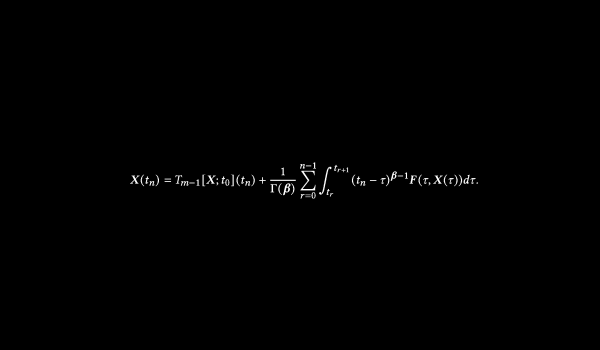

None

Predicted formula:
 <S> \chi _ { ( n ) } \, \mathrm { ~ x f o r } , t _ { a r ~ l } ) \longleftrightarrow \frac { 1 } { \Gamma ( B } \sum _ { r \in V } ^ { a v } \int _ { k } ^ { c . v } ( t _ { n } - r \rho _ { C } ( \tau , \chi ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [30]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/Screen Shot_14.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Downscaling big images
if w > 600:
    new_w = 400
    new_h = int(new_w * aspect)
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)


if w<200:
    image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]
elif w < 350:
    image_tensor = Image_Transforms.test_transform_with_padding_small(image=np.array(image))['image'][:1]
elif w<600:
    image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
else:
    image_tensor = Image_Transforms.test_transform_with_padding_xl(image=np.array(image))['image'][:1]
    
    
#image_tensor = Image_Transforms.test_transform_with_padding_medium(image=np.array(image))['image'][:1]    

print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

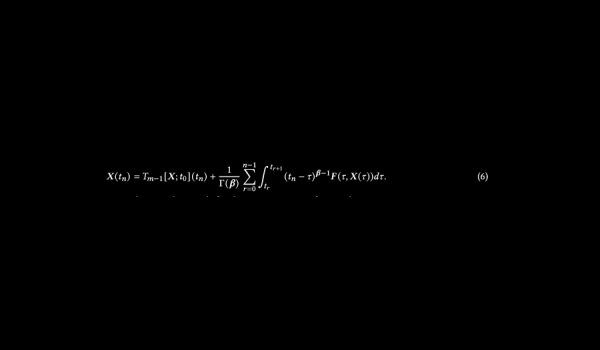

None

Predicted formula:
 <S> \mathrm { ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~


<IPython.core.display.Math object>

None


In [13]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Downscaling big images
if w > 600:
    new_w = 600
    new_h = int(new_w * aspect)
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)


if w<200:
    image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]
elif w < 350:
    image_tensor = Image_Transforms.test_transform_with_padding_small(image=np.array(image))['image'][:1]
elif w<600:
    image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
else:
    image_tensor = Image_Transforms.test_transform_with_padding_xl(image=np.array(image))['image'][:1]
    
    
    
print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

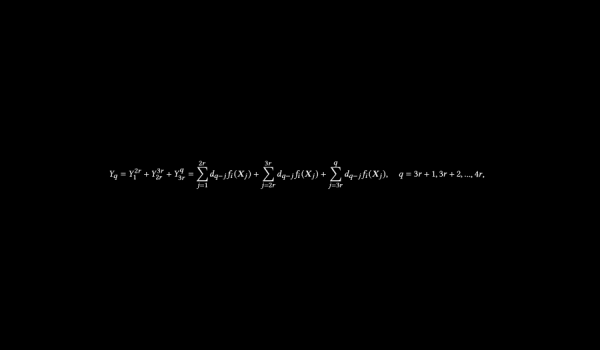

None

Predicted formula:
 <S> _ { v _ { s } \cdot \lambda ^ { \prime } \cdot \gamma _ { p } \cdot \tau _ { p } ^ { \sigma } \cdot \tau _ { p } \cdot \bar { \beta } _ { t } \epsilon , \rho \chi ) . \hat { \xi } _ { e r } \rho ( \chi ) \cdot \hat { \varphi } _ { e _ { \tau } \rho ( \chi ) } \quad \eta \cdot \cdot p \cdot . . . . . . . c . } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [14]:
## ALB

image_path= "Jupyter_Notebooks/test_photos/Screen Shot_10.png"

image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
image = cv2.bitwise_not(image)
image = findPositions(image)
h, w, c = image.shape
aspect = h / w

image = findPositions(image)

# Thresholding
if w > 400:
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Downscaling big images
if w > 600:
    new_w = 600
    new_h = int(new_w * aspect)
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)


if w<200:
    image_tensor = Image_Transforms.test_transform_with_padding_xs(image=np.array(image))['image'][:1]
elif w < 350:
    image_tensor = Image_Transforms.test_transform_with_padding_small(image=np.array(image))['image'][:1]
elif w<600:
    image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
else:
    image_tensor = Image_Transforms.test_transform_with_padding_xl(image=np.array(image))['image'][:1]
    
    
    
print(display(transform(image_tensor)))



#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))